In [1]:
from data_processing import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
import numpy as np
from noise import NoiseScheduler
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

from tqdm import tqdm


In [2]:
baseDir='/hdfs/user/ys20884/hackathon/data'
dataset = Dataset(20000, (120, 72), signal_file=f"{baseDir}/CaloImages_signal.root", pile_up_file=f"{baseDir}/CaloImages_bkg.root", save=False)

In [3]:
dataset() #once this is cached, you don't have to re-load

In [ ]:
new_dim=(64,64)

dataset.preprocess(16, new_dim)

preprocess = transforms.Compose(
        [
            transforms.ToTensor()
        ]
)

clean_frames = preprocess(dataset.signal).float().permute(1, 2, 0).unsqueeze(1) #pytorch symantics
pile_up = preprocess(dataset.pile_up).float().permute(1, 2, 0).unsqueeze(1)

clean_bkg = torch.zeros(clean_frames.shape)


INFO:root:scaling
scaling


AttributeError: 'Dataset' object has no attribute 'signal_tensor'

In [ ]:
noise_scheduler = NoiseScheduler('pile-up')
timestep = torch.LongTensor([40]) #each unit of timestep represents an addtional 5 pile-up events
n_events = 20000

noisy_signal_images = []
noisy_bkg_images = []

for clean_frame in clean_frames:
    random_seed = np.random.randint(0, n_events)
    noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frame, noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = n_events)
    noisy_signal_images.append(noisy_image)

for clean_frame in clean_bkg:
    random_seed = np.random.randint(n_events, n_events*2)
    noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frame, noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = n_events)
    noisy_bkg_images.append(noisy_image)

In [ ]:
print (noisy_signal_images[0].shape)
print (noisy_bkg_images[0].shape)


torch.Size([1, 64, 64])
torch.Size([1, 64, 64])


In [ ]:
# Combine the datasets and create labels
labels = torch.cat([torch.ones(len(noisy_signal_images)), torch.zeros(len(noisy_bkg_images))], dim=0)
images = noisy_signal_images + noisy_bkg_images

# Train-test split
images_train, images_test, labels_train, labels_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Create a DataLoader for training and testing sets
train_dataset = TensorDataset(torch.stack(images_train), labels_train)
test_dataset = TensorDataset(torch.stack(images_test), labels_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(8 * 16 * 16, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 8 * 16 * 16)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Instantiate the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
if torch.cuda.is_available():
    print("CUDA is available!")
    print("Number of available GPUs:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.current_device())
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available!
Number of available GPUs: 6
Current GPU: 0


In [ ]:
# Train the model
epochs = 1
for epoch in range(epochs):
    progress_bar = tqdm(total=len(train_dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
        logs = {"loss": loss.detach().item()}
        progress_bar.set_postfix(**logs)
        # progress_bar.set_postfix(**logs)



Epoch 0: 100%|██████████| 250/250 [00:02<00:00, 106.17it/s, loss=0.417]

In [ ]:
# Evaluate the model on the test set and plot ROC curve
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        all_labels.extend(labels.numpy())
        all_preds.extend(torch.sigmoid(outputs).numpy())

In [ ]:
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

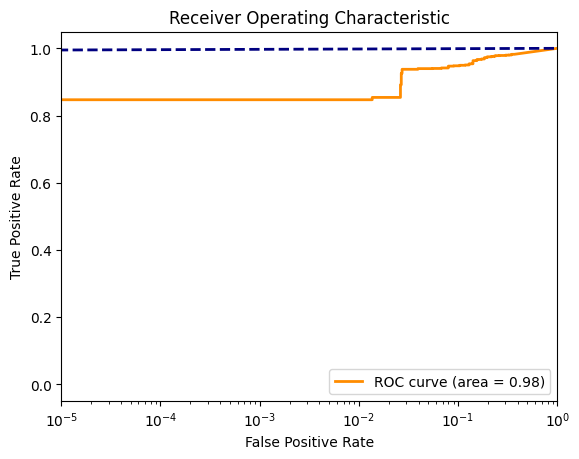

Epoch 0: 100%|██████████| 250/250 [00:15<00:00, 106.17it/s, loss=0.417]

In [ ]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xscale('log')
plt.xlim(1e-5, 1)  # Adjust the x-axis limits
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()